In [1]:
# Cell 1: Imports and settings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
import joblib
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
RANDOM_STATE = 42

In [2]:
# Cell 2: Load dataset
df = pd.read_csv('../backend/Telco-Customer-Churn.csv')  # adjust path if needed
df.shape, df.columns.tolist()

((7043, 21),
 ['customerID',
  'gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'tenure',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'MonthlyCharges',
  'TotalCharges',
  'Churn'])

In [3]:
# Cell 3: Quick EDA
df.head()
df.info()
df.isnull().sum()
df['Churn'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

In [4]:
# Cell 4: Clean TotalCharges and drop customerID
df = df.copy()
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Convert TotalCharges to numeric and impute
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Trim whitespace from object columns
for c in df.select_dtypes('object').columns:
    df[c] = df[c].str.strip()

In [5]:
# Cell 5: Feature engineering
# avg_monthly_spend (handle tenure == 0)
df['avg_monthly_spend'] = df.apply(lambda r: r['TotalCharges']/r['tenure'] if r['tenure']>0 else r['MonthlyCharges'], axis=1)
# services_count - count of positive service flags
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
def services_count(row):
    cnt=0
    for s in services:
        val = row.get(s)
        if pd.isna(val): continue
        if val in ['Yes','Male','Female'] and s!='InternetService':  # generic
            if val == 'Yes': cnt+=1
        elif s == 'InternetService':
            if val != 'No': cnt+=1
    return cnt
df['services_count'] = df.apply(lambda r: sum(1 for s in services if (r[s] not in [np.nan, 'No', 'no', ''] and r[s] != 'No')), axis=1)

# quick boolean helper
df['has_internet'] = df['InternetService'].apply(lambda x: 0 if x=='No' else 1)
df['is_new_customer'] = (df['tenure'] <= 3).astype(int)
df['high_monthly'] = (df['MonthlyCharges'] > df['MonthlyCharges'].quantile(0.75)).astype(int)

In [6]:
# Cell 6: Prepare target and feature lists
df['ChurnLabel'] = df['Churn'].map({'No':0, 'Yes':1})
y = df['ChurnLabel']

# Choose features to use (we'll use many; later we can select)
# Exclude columns that leak info or are redundant
excluded = ['Churn','ChurnLabel']
use_cols = [c for c in df.columns if c not in excluded and c != 'TotalCharges']  # keep TotalCharges processed -> it's present though; adjust if needed
# We'll list numeric and categorical separately
numeric_cols = ['tenure','MonthlyCharges','TotalCharges','avg_monthly_spend','services_count']
cat_cols = [c for c in use_cols if c not in numeric_cols]
# remove duplicates if any
cat_cols = [c for c in cat_cols if c in df.columns and df[c].dtype=='object' or df[c].dtype=='int64' or df[c].dtype=='float64']
# we'll refine below - best to pick known categorical columns:
fixed_cat_cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
                  'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                  'StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
# ensure they exist
cat_cols = [c for c in fixed_cat_cols if c in df.columns]
numeric_cols = [c for c in numeric_cols if c in df.columns]
numeric_cols, cat_cols

(['tenure',
  'MonthlyCharges',
  'TotalCharges',
  'avg_monthly_spend',
  'services_count'],
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'])

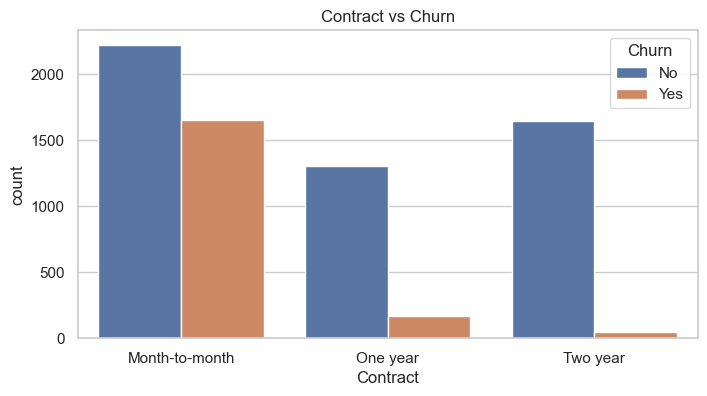

In [7]:
# Cell 7: Quick distributions & churn rate by contract (visual)
plt.figure(figsize=(8,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract vs Churn')
plt.show()

In [8]:
# Cell 8: Preprocessing pipeline (sklearn)
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For tree-based models we can use OrdinalEncoder for some features, but to keep consistent we'll use OneHot for most categorical features.
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('num', scaler, numeric_cols),
    ('cat', ohe, cat_cols)
], remainder='drop', verbose_feature_names_out=False)


In [9]:
# Cell 9: Train/test split (stratified)
X = df[numeric_cols + cat_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((5634, 21),
 (1409, 21),
 np.float64(0.2653532126375577),
 np.float64(0.2654364797728886))

In [10]:
# Cell 10: Baseline models training & comparison
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
# Optional: import xgboost, lightgbm, catboost if available
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None
try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "GaussianNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
}
if XGBClassifier:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
if LGBMClassifier:
    models['LightGBM'] = LGBMClassifier(random_state=RANDOM_STATE)
if CatBoostClassifier:
    models['CatBoost'] = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)

results = []
from sklearn.pipeline import make_pipeline
for name, mdl in models.items():
    pipe = make_pipeline(preprocessor, mdl)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    results.append((name, acc, f1, roc))
    print(f"{name:12s}  Acc: {acc:.4f}  F1: {f1:.4f}  ROC-AUC: {roc:.4f}")
    
results_df = pd.DataFrame(results, columns=['model','accuracy','f1','roc_auc']).sort_values('roc_auc', ascending=False)
results_df

LogisticRegression  Acc: 0.8062  F1: 0.6061  ROC-AUC: 0.8419
DecisionTree  Acc: 0.7282  F1: 0.4993  ROC-AUC: 0.6585
KNN           Acc: 0.7637  F1: 0.5530  ROC-AUC: 0.7874
SVM           Acc: 0.7949  F1: 0.5628  ROC-AUC: 0.7937
GaussianNB    Acc: 0.6927  F1: 0.5911  ROC-AUC: 0.8064
RandomForest  Acc: 0.7857  F1: 0.5438  ROC-AUC: 0.8223
ExtraTrees    Acc: 0.7700  F1: 0.5291  ROC-AUC: 0.7922
AdaBoost      Acc: 0.8020  F1: 0.5854  ROC-AUC: 0.8451
GradientBoosting  Acc: 0.7913  F1: 0.5559  ROC-AUC: 0.8376
XGBoost       Acc: 0.7864  F1: 0.5580  ROC-AUC: 0.8210


,model,accuracy,f1,roc_auc
7,AdaBoost,0.801987,0.585438,0.845132
0,LogisticRegression,0.806246,0.606061,0.841856
8,GradientBoosting,0.791341,0.555891,0.837617
5,RandomForest,0.785664,0.543807,0.822337
9,XGBoost,0.786373,0.558003,0.820974
4,GaussianNB,0.692690,0.591124,0.806407
3,SVM,0.794890,0.562784,0.793733
6,ExtraTrees,0.770050,0.529070,0.792203
2,KNN,0.763662,0.553020,0.787418
1,DecisionTree,0.728176,0.499346,0.658493


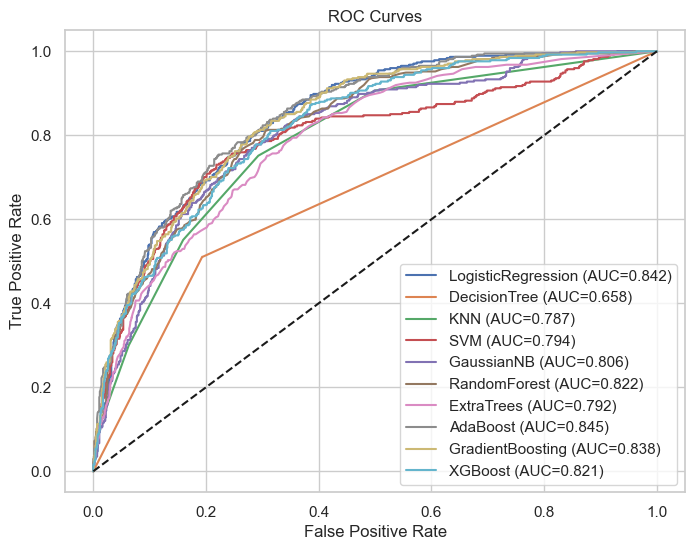

In [11]:
# Cell 11: Plot ROC curves for top models (up to 6)
plt.figure(figsize=(8,6))
i=0
for name, mdl in models.items():
    pipe = make_pipeline(preprocessor, mdl)
    pipe.fit(X_train, y_train)
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

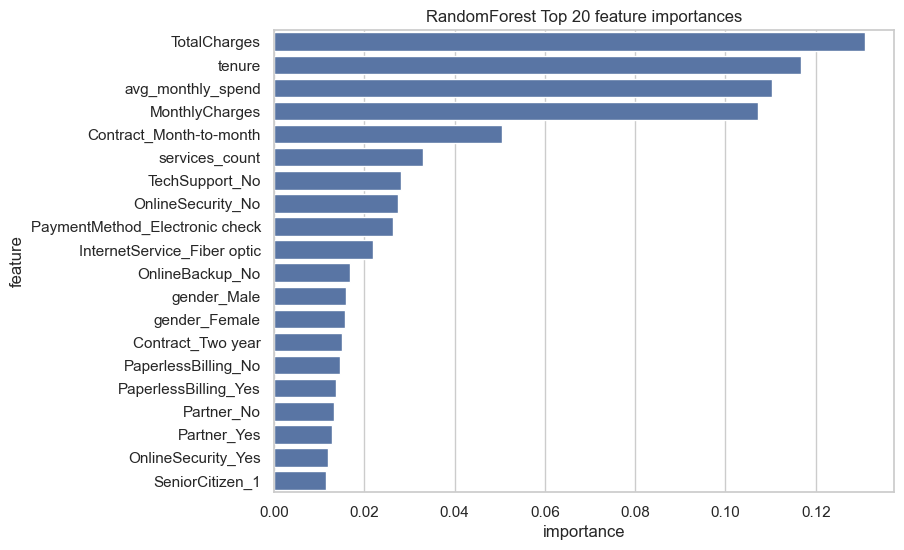

,feature,importance
2,TotalCharges,0.130823
0,tenure,0.116655
3,avg_monthly_spend,0.110197
1,MonthlyCharges,0.107311
39,Contract_Month-to-month,0.050498
4,services_count,0.032925
30,TechSupport_No,0.028003
21,OnlineSecurity_No,0.027505
46,PaymentMethod_Electronic check,0.026275
19,InternetService_Fiber optic,0.021945


In [12]:
# Cell 12: Feature importance from RandomForest and XGBoost (if available)
best_rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))
best_rf.fit(X_train, y_train)

# feature names after preprocessor
feature_names_num = numeric_cols
feature_names_cat = list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols))
feature_names = feature_names_num + feature_names_cat

rf_importances = best_rf.named_steps['randomforestclassifier'].feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': rf_importances}).sort_values('importance', ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=imp_df)
plt.title('RandomForest Top 20 feature importances')
plt.show()
imp_df.head(10)

In [13]:
# Cell 13: Hyperparameter tuning example (RandomizedSearch for XGBoost or RandomForest)
from sklearn.model_selection import RandomizedSearchCV

# Tune RandomForest - example
rf = RandomForestClassifier(random_state=RANDOM_STATE)
param_dist = {
    'n_estimators':[100,200,400,600],
    'max_depth':[6,10,15,20,None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4],
    'class_weight':[None, 'balanced']
}
pipe_rf = make_pipeline(preprocessor, rf)
rs = RandomizedSearchCV(pipe_rf, {'randomforestclassifier__n_estimators':param_dist['n_estimators'],
                                  'randomforestclassifier__max_depth':param_dist['max_depth'],
                                  'randomforestclassifier__min_samples_split':param_dist['min_samples_split'],
                                  'randomforestclassifier__min_samples_leaf':param_dist['min_samples_leaf'],
                                  'randomforestclassifier__class_weight':param_dist['class_weight']},
                        n_iter=30, cv=5, scoring='f1', verbose=1, random_state=RANDOM_STATE, n_jobs=-1)
rs.fit(X_train, y_train)
print("Best RF params:", rs.best_params_)
rf_best = rs.best_estimator_
y_pred_rf = rf_best.predict(X_test)
print("RF best test acc/f1:", accuracy_score(y_test,y_pred_rf), f1_score(y_test,y_pred_rf))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__class_weight': 'balanced'}
RF best test acc/f1: 0.7643718949609652 0.6227272727272727


In [14]:
# Cell 14: Hyperparameter tuning example for XGBoost (if installed)
if XGBClassifier:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
    param_dist = {
        'xgbclassifier__n_estimators':[100,200,400],
        'xgbclassifier__learning_rate':[0.01,0.05,0.1],
        'xgbclassifier__max_depth':[3,5,7],
        'xgbclassifier__subsample':[0.6,0.8,1],
        'xgbclassifier__colsample_bytree':[0.6,0.8,1]
    }
    pipe_xgb = make_pipeline(preprocessor, xgb)
    rs_xgb = RandomizedSearchCV(pipe_xgb, param_dist, n_iter=30, cv=5, scoring='f1', random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
    rs_xgb.fit(X_train, y_train)
    xgb_best = rs_xgb.best_estimator_
    y_pred_xgb = xgb_best.predict(X_test)
    print("XGB best test acc/f1:", accuracy_score(y_test,y_pred_xgb), f1_score(y_test,y_pred_xgb))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
XGB best test acc/f1: 0.8069552874378992 0.5878787878787879


In [15]:
# Cell 15: Stacking top estimators (example: RF + XGB + LGBM if available)
from sklearn.ensemble import StackingClassifier
estimators = []
if 'rf_best' in globals():
    estimators.append(('rf', rf_best.named_steps['randomforestclassifier']))
if 'xgb_best' in globals():
    estimators.append(('xgb', xgb_best.named_steps.get('xgbclassifier', xgb_best.named_steps.get('xgbclassifier'))))
# For stacking we need raw preprocessed data or to use pipeline trick. Here we'll build a combined pipeline:
# Recreate fitted preprocessor on full train data and save it
preprocessor.fit(X_train)
joblib.dump(preprocessor, '../backend/model/preprocessor.pkl')

# Build final estimators using their best params manually (easier reproducibility)
final_rf = RandomForestClassifier(n_estimators=rs.best_estimator_.named_steps['randomforestclassifier'].n_estimators,
                                  max_depth=rs.best_estimator_.named_steps['randomforestclassifier'].max_depth,
                                  random_state=RANDOM_STATE) if 'rs' in globals() else RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)

final_estimators = [('rf', final_rf)]
if XGBClassifier and 'rs_xgb' in globals():
    final_estimators.append(('xgb', XGBClassifier(**{k.replace('xgbclassifier__',''):v for k,v in rs_xgb.best_params_.items()})))
# Stacking with final pipeline
stack_pipe = make_pipeline(preprocessor,
                           StackingClassifier(estimators=final_estimators, final_estimator=LogisticRegression(max_iter=1000), cv=5, n_jobs=-1))
stack_pipe.fit(X_train, y_train)
y_pred_stack = stack_pipe.predict(X_test)
print("Stacking test acc/f1:", accuracy_score(y_test,y_pred_stack), f1_score(y_test,y_pred_stack))

Stacking test acc/f1: 0.8041163946061036 0.5792682926829268


In [16]:
# Cell 16: Save final artifact (choose best model: stack_pipe or rf_best or xgb_best)
final_model = stack_pipe
os.makedirs('../backend/model', exist_ok=True)
joblib.dump({'model': final_model, 'preprocessor': preprocessor, 'feature_cols': numeric_cols + cat_cols}, '../backend/model/churn_artifact.pkl')
print("Saved final artifact to ../backend/model/churn_artifact.pkl")

Saved final artifact to ../backend/model/churn_artifact.pkl


Accuracy: 0.8041163946061036
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



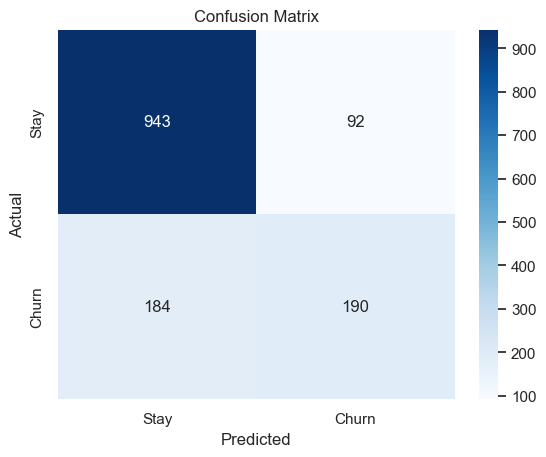

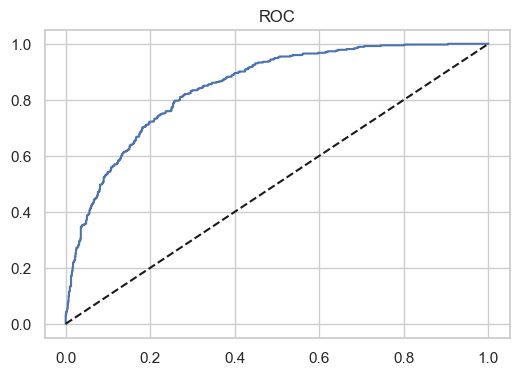

ROC AUC: 0.8468508615567438


In [17]:
# Cell 17: Final evaluation report - confusion matrix and classification report
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1] if hasattr(final_model, "predict_proba") else None
print("Accuracy:", accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay','Churn'], yticklabels=['Stay','Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,4)); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'k--'); plt.title('ROC'); plt.show()
    print("ROC AUC:", roc_auc_score(y_test,y_proba))

In [18]:
# Cell 18: SHAP explanation (optional, if you have shap installed)
try:
    import shap
    explainer = shap.Explainer(final_model.named_steps[list(final_model.named_steps.keys())[-1]])
    # NOTE: stacking wrapper may complicate direct SHAP usage; you can use tree explainer for RF/XGB directly
except Exception as e:
    print("SHAP not available or not configured:", e)

SHAP not available or not configured: No module named 'shap'
